# Forming Issue Frames

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic.representation import KeyBERTInspired
import umap
from umap import UMAP
from hdbscan import HDBSCAN
import re
import nltk
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import unicodedata
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

In [ ]:
# load BERTopic models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
reddit_model = BERTopic.load("final_reddit_model", embedding_model=embedding_model)
news_model = BERTopic.load("final_news_model", embedding_model=embedding_model)

In [ ]:
# load data
reddit = pd.read_csv("reddit_cleaned.csv")
news = pd.read_csv("news_cleaned.csv")

In [ ]:
# get total articles by publication
news["news"].value_counts()

news
express        1176
telegraph      1089
independent     999
daily-mail      826
times           680
bbc             653
sun             469
guardian        453
mirror          436
metro           172
Name: count, dtype: int64

# Passing Custom Topic Labels

## News

In [ ]:
news_topic_labels = {
    0: "1: Rwanda Court Ruling",
    1: "2: Asylum Seekers Accommodation",
    2: "3: Taliban Convictions",
    3: "4: Braverman Immigration Policy",
    4: "5: Migration Record Figures",
    5: "6: Rishi Sunak Politics",
    6: "7: Illegal Migration Legislation",
    7: "8: Migrants Crossing",
    8: "9: RAF Scampton Asylum",
    9: "10: Migrant Boat Tragedies",
    10: "11: Bibby Stockholm Barge",
    11: "12: EU Migration Deal",
    12: "13: UK Police Crimes",
    13: "14: Protests at Hotels",
    14: "15: Migrant Smuggling Gangs",
    15: "16: Gary Lineker Controversy",
    16: "17: Foreign Worker Visas",
    17: "18: Asylum Claims Backlog",
    18: "19: Missing Unaccompanied Children",
    19: "20: Legionella on Barge",
    20: "21: Portland Asylum Barge",
    21: "22: Stopping Migrant Boats",
    22: "23: Emmanuel Macron Politics",
    23: "24: Foreign University Students",
    24: "25: European Human Rights",
    25: "26: Archbishop on Migration"
}

news_model.set_topic_labels(news_topic_labels)

## Reddit

In [ ]:
# create manual topic labels
reddit_topic_labels = {
    -1: "0: Outliers",
    0: "1: Visa and Immigration Advice",
    1: "2: Asylum Seeking Issues",
    2: "3: British Culture",
    3: "4: Human Rights",
    4: "5: Housing Issues and Refugees",
    5: "6: British Citizenship",
    6: "7: Israel–Hamas war",
    7: "8: Expat Experiences",
    8: "9: Multiculturalism in UK",
    9: "10: Police Detention",
    10: "11: International Medical Students and NHS",
    11: "12: Russian-Ukraine War",
    12: "13: Immigration and Labour",
    13: "14: Left-wing Immigration Politics",
    14: "15: Economic Impact of Immigration",
    15: "16: Brexit and Immigration",
    16: "17: Asylum Boat Arrivals",
    17: "18: Immigration Protests",
    18: "19: European Migration",
    19: "20: Visa and Living Costs",
    20: "21: Gary Lineker Controversy",
    21: "22: Home Office",
    22: "23: Immigration in London",
    23: "24: Court settlements",
    24: "25: Legal Immigration",
    25: "26: Mass immigration",
    26: "27: Criminality and Law Enforcement",
    27: "28: Immigration Enforcement",
    28: "29: Assimilation of Immigrants",
    29: "30: Career pathways for Immigrants",
    30: "31: Mental health",
    31: "32: Policing",
    32: "33: Child Marriage",
    33: "34: Immigration and Healthy Economy",
    34: "35: Remote work and Isolation",
    35: "36: South African Apartheid and Foreigners"
}
# assign topic labels
reddit_model.set_topic_labels(reddit_topic_labels)

# Issue Frames

### Intermedia Cosine Similarity

In [ ]:
from scipy.cluster import hierarchy
import plotly.graph_objects as go

# Function to extract topic embeddings
def extract_topic_embeddings(model, embedding_model):
    topic_info = model.get_topic_info()
    topic_embeddings = []
    labels = []
    for topic in topic_info['Topic']:
        if topic == -1: 
            continue
        topic_words = model.get_topic(topic)
        if topic_words is None:  
            continue
        words = [word for word, _ in topic_words]
        embeddings = embedding_model.encode(words)
        topic_embedding = np.mean(embeddings, axis=0)
        topic_embeddings.append(topic_embedding)
        labels.append(model.get_topic_info().loc[model.get_topic_info()['Topic'] == topic, 'CustomName'].values[0])
    return np.array(topic_embeddings), labels

# Extract topic embeddings and labels
reddit_embeddings, reddit_labels = extract_topic_embeddings(reddit_model, embedding_model)
news_embeddings, news_labels = extract_topic_embeddings(news_model, embedding_model)

# Calculate cosine similarity
cosine_sim = cosine_similarity(reddit_embeddings, news_embeddings)

# Perform hierarchical clustering on both axes
dendrogram_row = hierarchy.linkage(cosine_sim, method='average')
dendrogram_col = hierarchy.linkage(cosine_sim.T, method='average')

# Reorder rows and columns based on clustering
idx_row = hierarchy.dendrogram(dendrogram_row, no_plot=True, orientation='top')['leaves']
idx_col = hierarchy.dendrogram(dendrogram_col, no_plot=True, orientation='left')['leaves']

# Reorder cosine similarity matrix
cosine_sim_reordered = cosine_sim[idx_row, :][:, idx_col]

# Convert labels to numpy arrays for indexing
reddit_labels = np.array(reddit_labels)
news_labels = np.array(news_labels)

# Create interactive heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=cosine_sim_reordered,
    x=news_labels[idx_col],
    y=reddit_labels[idx_row],
    colorscale='Magenta'))

fig.update_layout(
    title='Intermedia Cosine Similarity: How Similar are Reddit and News Topics on Immigration?',
    xaxis_title='News Topics',
    yaxis_title='Reddit Topics',
    height=1200,  
    width=1500, 
    xaxis=dict(tickangle=45, side='bottom'))  


fig.show()


In [ ]:
# save the plot
fig.write_html("intermedia-cosine_similarity.html")

In [ ]:
# get an overall similarity score
overall_similarity = np.mean(cosine_sim_reordered)

In [ ]:
overall_similarity

0.6649707

In [ ]:
# standard deviation
overall_std = np.std(cosine_sim_reordered)

overall_std

0.077134766

In [ ]:
# get pairs with cosine similarity > 0.8
similar_pairs = []
for reddit_topic, news_topic in zip(*np.where(cosine_sim > 0.8)):
    reddit_topic_name = reddit_labels[reddit_topic]
    news_topic_name = news_labels[news_topic]
    similarity = cosine_sim[reddit_topic, news_topic]
    similar_pairs.append((news_topic_name, reddit_topic_name))

intermedia_df = pd.DataFrame(similar_pairs, columns=["News Topic", "Reddit Topic"])
# group by news topic
intermedia_df = intermedia_df.groupby("News Topic")["Reddit Topic"].apply(list).reset_index()

In [ ]:
intermedia_df

### News Cosine Similarity

In [ ]:
import pandas as pd

# Initialize an empty list to store similar pairs
news_similarity = []

# Iterate through all combinations of news topics
for i in range(len(news_labels)):
    for j in range(len(news_labels)):
        if i != j:  # Ensure i and j are not the same
            similarity = cosine_similarity(news_embeddings[i].reshape(1, -1), news_embeddings[j].reshape(1, -1))[0][0]
            if similarity > 0.75:
                news_similarity.append((news_labels[i], news_labels[j]))

# Create a DataFrame from the list of similar pairs
news_similarity_df = pd.DataFrame(news_similarity, columns=["News Topic", "Similar News Topic"])

# Sort the DataFrame by "News Topic" for clarity
news_similarity_df = news_similarity_df.sort_values("News Topic").reset_index(drop=True)

news_similarity_df = news_similarity_df.groupby("News Topic")["Similar News Topic"].apply(list).reset_index()

In [ ]:
news_similarity_df

In [ ]:
# Merge with similar_pairs_df
intermedia_df['Similar News Topic'] = intermedia_df['News Topic'].map(news_similarity_df.set_index('News Topic')['Similar News Topic'])
# reorder columns
intermedia_df = intermedia_df[['News Topic', 'Similar News Topic', 'Reddit Topic']]

In [ ]:
intermedia_df

In [ ]:
# Combine news topics into one column
intermedia_df['Combined News Topics'] = intermedia_df.apply(lambda row: f"{row['News Topic']}, {', '.join(row['Similar News Topic']) if isinstance(row['Similar News Topic'], list) else row['Similar News Topic']}", axis=1)

# remove the word ', nan' from the combined news topics
intermedia_df['Combined News Topics'] = intermedia_df['Combined News Topics'].str.replace(', nan', '')

# keep only the relevant columns
issue_frame_df = intermedia_df[['Combined News Topics','Reddit Topic']]

# Convert the list column to strings
issue_frame_df['Reddit Topic'] = issue_frame_df['Reddit Topic'].apply(lambda x: str(x))

# Remove the square brackets
issue_frame_df['Reddit Topic'] = issue_frame_df['Reddit Topic'].str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace("'", '', regex=False)

# rename to News Topic
issue_frame_df = issue_frame_df.rename(columns={'Combined News Topics': 'News Topic'})

In [ ]:
issue_frame_df

In [ ]:
# write to csv
issue_frame_df.to_csv("issue_frames.csv", index=False)

In [ ]:
reddit['topic'] = reddit_model.topics_
news['topic'] = news_model.topics_

In [ ]:
## asylum claims and housing
news_asylum = [1,8,10,17,20]
reddit_asylum = [1,4]

## criminality + law enforcement frame
news_crime = [2,12]
reddit_crime = [9,26,31]

## high legal immigration
news_visa = [4,16,23]
reddit_visa = [0,14,24,25]

## policy
news_policy = [0,3,6,11,13,15,24]
reddit_policy = [2,3,8,17,20]

## boat
news_boat = [7,9,14]
reddit_boat = [16]

In [ ]:
# Function to assign frame based on topic
def assign_frame(topic, asylum_list, crime_list, visa_list, policy_list, boat_list):
    if topic in visa_list:
        return 'visa'
    elif topic in crime_list:
        return 'criminality'
    elif topic in asylum_list:
        return 'asylum'
    elif topic in policy_list:
        return 'policy'
    elif topic in boat_list:
        return 'boat'
    else:
        return None

# Apply the function to the news dataset
news['frame'] = news['topic'].apply(lambda x: assign_frame(x,news_asylum, news_crime, news_visa, news_policy, news_boat))

# Apply the function to the reddit dataset
reddit['frame'] = reddit['topic'].apply(lambda x: assign_frame(x,reddit_asylum, reddit_crime, reddit_visa, reddit_policy, reddit_boat))

In [ ]:
# remove rows with no frame
news = news.dropna(subset=['frame'])
reddit = reddit.dropna(subset=['frame'])

In [ ]:
# count how many are in visa frame for reddit
reddit['frame'].value_counts()

frame
visa           5816
policy         2410
asylum         2210
criminality     601
boat            115
Name: count, dtype: int64

In [ ]:
# write to csv
news.to_csv("news_framed.csv", index=False)
reddit.to_csv("reddit_framed.csv", index=False)

In [ ]:
# count the number of articles per frame
news_frame_counts = news['frame'].value_counts()
reddit_frame_counts = reddit['frame'].value_counts()

# Convert Series to DataFrames
df_news = news_frame_counts.reset_index()
df_news.columns = ['frame', 'news']

df_reddit = reddit_frame_counts.reset_index()
df_reddit.columns = ['frame', 'reddit']

# Merge dataframes on 'frame' column
frame_counts = pd.merge(df_news, df_reddit, on='frame', how='outer').fillna(0)

# rename frame values
frame_counts['frame'] = frame_counts['frame'].replace({'visa': 'Legal Immigration', 
                                                       'criminality': 'Criminality and \nLaw Enforcement', 
                                                       'asylum': 'Asylum Claims and \nHousing', 
                                                       'policy': 'Immigration Policy \nResponses', 
                                                       'boat': 'Migrant Boat Arrivals'})
frame_counts=frame_counts.sort_values(by='frame')


In [ ]:
frame_counts

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

frame_counts.plot(kind='bar', x='frame', ax=ax, color=['#008080', '#cc0000'], alpha=0.75)
ax.set_title('Number of Articles and Comments per Frame in Reddit and News', fontsize=16)
ax.set_xlabel('Frame', fontsize=12)
ax.legend(['News', 'Reddit'])
plt.xticks(rotation=0, fontsize=10)

# Remove grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Frame Prevalence Analysis

In [2]:
# open framed news 
news = pd.read_csv('news_framed.csv')

In [3]:
# leaning
left_wing = ["mirror", "guardian", "independent"]
right_wing = ["sun", "daily-mail", "telegraph", "express", "times"]
neutral = ["bbc", "metro"]

# add political leaning as column to news 
news['leaning'] = None
for index, row in news.iterrows():
    if row['news'] in left_wing:
        news.loc[index, 'leaning'] = "left"
    elif row['news'] in right_wing:
        news.loc[index, 'leaning'] = "right"
    else:
        news.loc[index, 'leaning'] = "neutral"
        

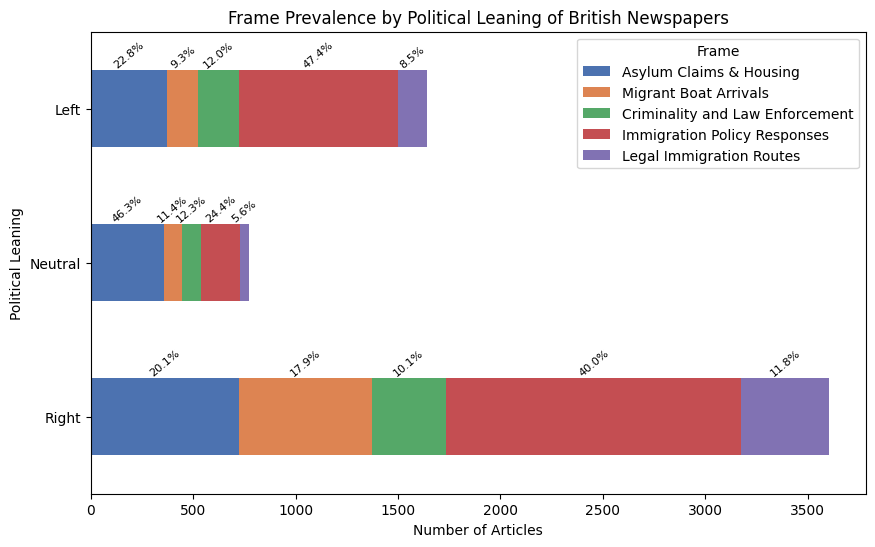

In [4]:
frame_count = news.groupby(['leaning', 'frame']).size().unstack().fillna(0)
# Calculate percentages
frame_percentage = frame_count.div(frame_count.sum(axis=1), axis=0) * 100
# reindex such that the order is right, neutral, left
frame_count = frame_count.reindex(['right', 'neutral', 'left'])

# Update the index labels for clarity
frame_count.index = ['Right', 'Neutral', 'Left']

# Set the color palette
sns.set_palette('deep')

# Plot
ax = frame_count.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('Frame Prevalence by Political Leaning of British Newspapers')

plt.xticks(rotation=0)
plt.legend(title='Frame', labels=['Asylum Claims & Housing', 
                                  'Migrant Boat Arrivals', 
                                  'Criminality and Law Enforcement',
                                  'Immigration Policy Responses',
                                  'Legal Immigration Routes'])
plt.ylabel('Political Leaning')
plt.xlabel('Number of Articles')

# Annotate percentages on top of each slice
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width  / 2
    y = p.get_y() + height
    leaning = frame_count.index[int(p.get_y() + p.get_height() / 2)]
    total = frame_count.sum(axis=1).loc[leaning]
    percentage = (width / total) * 100
    # Adjust x position slightly to the right for visibility and rotate the text
    ax.annotate(f'{percentage:.1f}%', (x, y), ha='center', va='bottom', fontsize=8, rotation=40)

plt.savefig('figures/frame_political.pdf', format='pdf')
plt.show()
